### Interpretabilidad de los resultados para el modelo de predicción

1. **Panorama del producto de datos** <br>

El producto de datos tiene como objetivo predecir las llamadas *verdaderas* que son reportadas al C5, esto se hará con un modelo que arrojé las probabilidades asociadas a los nuevos registros de llamadas para tener una lista priorizada de esas llamadas con tal de enviar el recurso solicitado a las personas cuyo reporte reportado tenga una alta probabilidad de ser una llamada **"afirmativa"**, ya que los recursos de la Cuidad de México son limitados y se desea hacer una correcta asignación de los mismos.

2. **Métrica en los modelos**

Se realizaron 3 modelos para las predicciones de la variable target **llamada afirmativa** (*Random Forest*, *XgBoost* y *Regresión Logística*), y la métrica utilizada en el *magic loop* de los 3 modelos fue **Precisión**. Se decidió esta métrica porque el enfoque va más dirigido a la correcta asignación de recursos limitados, con lo cual se busca controlar los *falsos positivos*, dado que no es deseable clasificar reportes de llamadas como *verdaderos* cuando realmente **no** lo sean.

3. **Bias y Fairness**

**Atributo Protegido**: Debido al objetivo del problema y la métrica elegida en el modelado, se elegió como atributo protegido a la *delegacion_inicio*, dado que las delegaciones de la Cuidad de México son heterogéneas ya que pueden ser distintas por su nivel de infraestructura, características de su población o su ubicación. Y justamente lo que se quiere evitar es que existan delegaciones marginadas o no atendidas por el simple hecho de tener atributos que la beneficien en comparación con otras. <br>

4. **Métricas de Fairness**: <br>
Se escogieron dos métricas: <br>
a)**False Negative Rate** <br>
b)**False Omission Rate**

In [1]:
#Librerias utilizadas
import pandas as pd
import seaborn as sns
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
from aequitas.plotting import Plot
from matplotlib import pyplot as plt
import numpy as np
import pprint
from sklearn.linear_model import LogisticRegression 
from aequitas.preprocessing import preprocess_input_df
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
#Carga de datos
X_train_input = pd.read_csv('X_train_input.csv', sep="\t")
X_test_input = pd.read_csv('X_test_input.csv', sep="\t") 
y_train = pd.read_csv('y_train.csv', sep="\t")
y_test = pd.read_csv('y_test.csv', sep="\t")
X_test= pd.read_csv('X_test.csv', sep="\t")

In [3]:
pprint.pprint("dimesiones X_train_input")
pprint.pprint(X_train_input.shape)
pprint.pprint("dimesiones X_test_input")
pprint.pprint(X_test_input.shape)
pprint.pprint("dimesiones y_train")
pprint.pprint(y_train.shape)
pprint.pprint("dimesiones y_test")
pprint.pprint(y_test.shape)

'dimesiones X_train_input'
(912188, 38)
'dimesiones X_test_input'
(390938, 38)
'dimesiones y_train'
(912188, 1)
'dimesiones y_test'
(390938, 1)


### Prueba con df_bias

In [4]:
df_bias = pd.read_csv('df_bias.csv', sep="\t")

In [5]:
df_bias

,mes,hora,delegacion_inicio,dia_semana,tipo_entrada,incidente_c4_rec,y_proba_0,y_proba_1,y_etiqueta,y_test
0,11,23,benito juarez,viernes,llamada del 066,accidente,0.541499,0.458501,0,1
1,11,19,cuauhtemoc,viernes,llamada del 066,lesionado,0.540023,0.459977,0,0
2,11,10,tlahuac,sabado,llamada del 911,lesionado,0.595743,0.404257,0,0
3,3,1,iztapalapa,domingo,boton de auxilio,accidente,0.516375,0.483625,0,1
4,8,16,cuauhtemoc,domingo,llamada del 066,lesionado,0.540023,0.459977,0,1
...,...,...,...,...,...,...,...,...,...,...
390933,7,10,cuauhtemoc,lunes,llamada del 911,accidente,0.567877,0.432123,0,1
390934,4,19,cuauhtemoc,miercoles,llamada del 911,accidente,0.593365,0.406635,0,0
390935,3,23,benito juarez,jueves,radio,accidente,0.434905,0.565095,1,1
390936,12,15,iztapalapa,martes,redes,accidente,0.579592,0.420408,0,0


In [6]:
#Se arma el df que requiere aequitas
df_aequitas =df_bias[['delegacion_inicio','y_etiqueta','y_test']]

In [7]:
df_aequitas

,delegacion_inicio,y_etiqueta,y_test
0,benito juarez,0,1
1,cuauhtemoc,0,0
2,tlahuac,0,0
3,iztapalapa,0,1
4,cuauhtemoc,0,1
...,...,...,...
390933,cuauhtemoc,0,1
390934,cuauhtemoc,0,0
390935,benito juarez,1,1
390936,iztapalapa,0,0


In [8]:
#Renombra columnas
df=df_aequitas.rename(columns={'y_etiqueta': 'score',
                            'y_test': 'label_value'})

In [9]:
df

,delegacion_inicio,score,label_value
0,benito juarez,0,1
1,cuauhtemoc,0,0
2,tlahuac,0,0
3,iztapalapa,0,1
4,cuauhtemoc,0,1
...,...,...,...
390933,cuauhtemoc,0,1
390934,cuauhtemoc,0,0
390935,benito juarez,1,1
390936,iztapalapa,0,0


In [10]:
#Asigna tipo apropiado de variable
df[df.columns.difference(['label_value', 'score'])] = df[
    df.columns.difference(['label_value', 'score'])].astype(str)

In [11]:
g = Group()
xtab, _ = g.get_crosstabs(df)

model_id, score_thresholds 1 {'rank_abs': [29749]}


In [12]:
#Obtiene todas las metricas absolutas
absolute_metrics = g.list_absolute_metrics(xtab)
xtab[[col for col in xtab.columns if col not in absolute_metrics]]

,model_id,score_threshold,k,attribute_name,attribute_value,pp,pn,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities
0,1,binary 0/1,29749,delegacion_inicio,alvaro obregon,1145,27743,114,10733,17010,1031,11764,17124,28888,390938
1,1,binary 0/1,29749,delegacion_inicio,azcapotzalco,1217,15987,79,6885,9102,1138,8023,9181,17204,390938
2,1,binary 0/1,29749,delegacion_inicio,benito juarez,5950,23861,1352,9894,13967,4598,14492,15319,29811,390938
3,1,binary 0/1,29749,delegacion_inicio,coyoacan,1436,30001,126,12104,17897,1310,13414,18023,31437,390938
4,1,binary 0/1,29749,delegacion_inicio,cuajimalpa,275,7336,35,2460,4876,240,2700,4911,7611,390938
5,1,binary 0/1,29749,delegacion_inicio,cuauhtemoc,6444,33885,868,15294,18591,5576,20870,19459,40329,390938
6,1,binary 0/1,29749,delegacion_inicio,gustavo a madero,2533,38485,166,16180,22305,2367,18547,22471,41018,390938
7,1,binary 0/1,29749,delegacion_inicio,iztacalco,1242,15244,117,6265,8979,1125,7390,9096,16486,390938
8,1,binary 0/1,29749,delegacion_inicio,iztapalapa,2819,60030,284,21949,38081,2535,24484,38365,62849,390938
9,1,binary 0/1,29749,delegacion_inicio,magdalena contreras,233,5397,20,1992,3405,213,2205,3425,5630,390938


In [13]:
xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,delegacion_inicio,alvaro obregon,0.09,0.99,0.39,0.10,0.01,0.91,0.61,0.90,0.04,0.04,0.41
1,delegacion_inicio,azcapotzalco,0.14,0.99,0.43,0.06,0.01,0.86,0.57,0.94,0.04,0.07,0.47
2,delegacion_inicio,benito juarez,0.32,0.91,0.41,0.23,0.09,0.68,0.59,0.77,0.20,0.20,0.49
3,delegacion_inicio,coyoacan,0.10,0.99,0.40,0.09,0.01,0.90,0.60,0.91,0.05,0.05,0.43
4,delegacion_inicio,cuajimalpa,0.09,0.99,0.34,0.13,0.01,0.91,0.66,0.87,0.01,0.04,0.35
5,delegacion_inicio,cuauhtemoc,0.27,0.96,0.45,0.13,0.04,0.73,0.55,0.87,0.22,0.16,0.52
6,delegacion_inicio,gustavo a madero,0.13,0.99,0.42,0.07,0.01,0.87,0.58,0.93,0.09,0.06,0.45
7,delegacion_inicio,iztacalco,0.15,0.99,0.41,0.09,0.01,0.85,0.59,0.91,0.04,0.08,0.45
8,delegacion_inicio,iztapalapa,0.10,0.99,0.37,0.10,0.01,0.90,0.63,0.90,0.09,0.04,0.39
9,delegacion_inicio,magdalena contreras,0.10,0.99,0.37,0.09,0.01,0.90,0.63,0.91,0.01,0.04,0.39


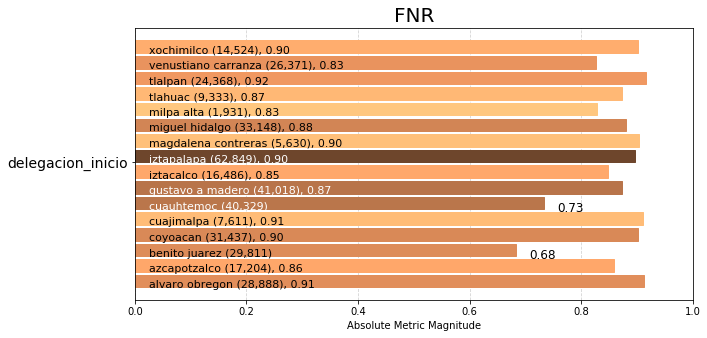

In [14]:
aqp = Plot()
fnr = aqp.plot_group_metric(xtab, 'fnr')

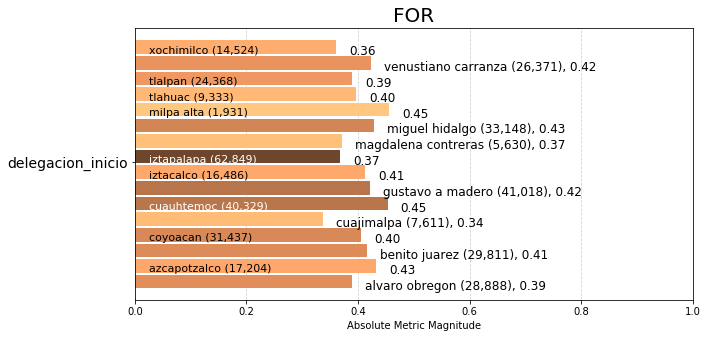

In [15]:
fnr = aqp.plot_group_metric(xtab, 'for')

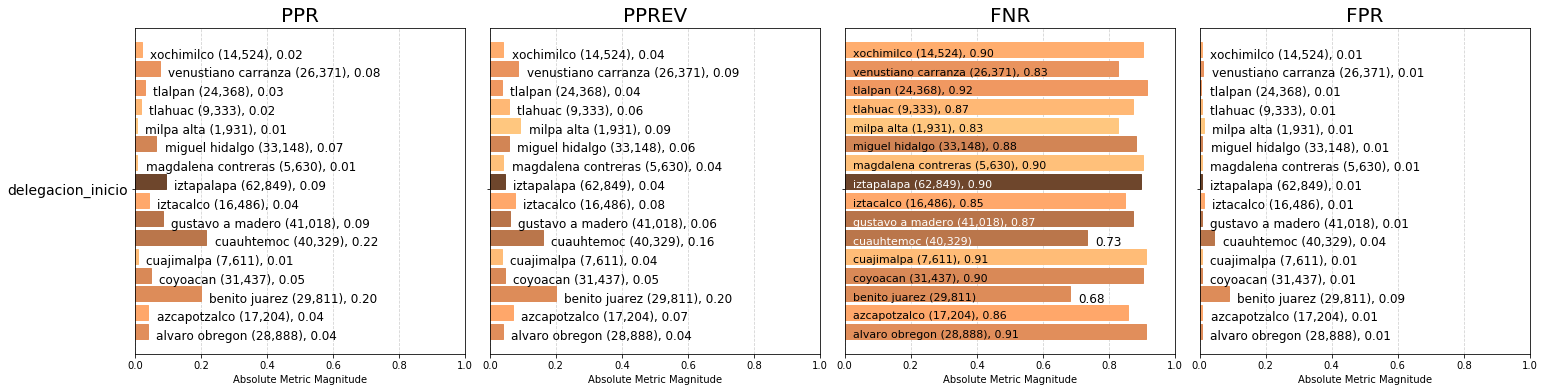

In [17]:
p = aqp.plot_group_metric_all(xtab, metrics=['ppr','pprev','fnr','fpr'], ncols=4)

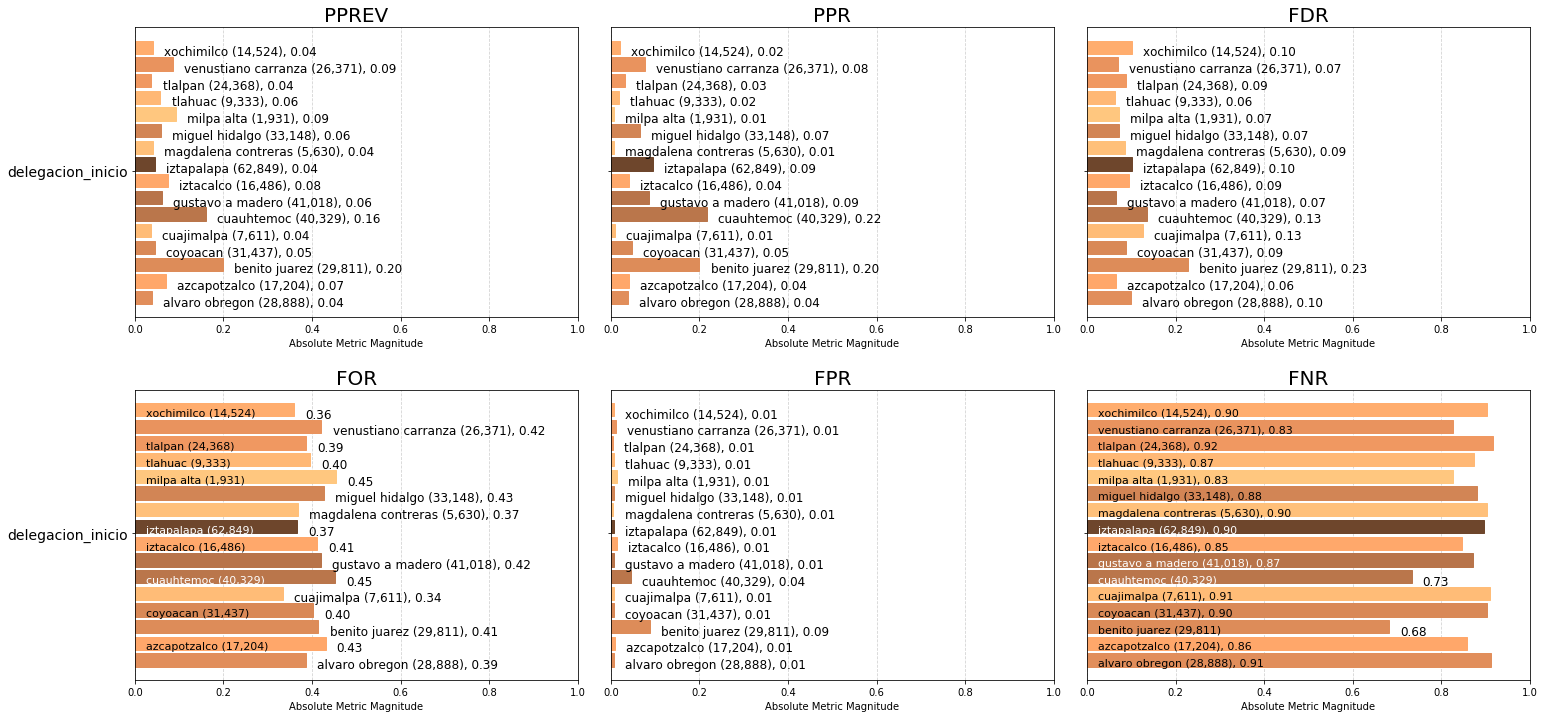

In [18]:
a = aqp.plot_group_metric_all(xtab, ncols=3)

In [19]:
#Disparidad en relación a un grupo especifico del atributo protegido
b = Bias()
bdf = b.get_disparity_predefined_groups(xtab, original_df=df, 
                                        ref_groups_dict={'delegacion_inicio':'coyoacan'},
                                        alpha=0.05, mask_significance=True)
bdf.style

get_disparity_predefined_group()


/Users/pozoshidalgo/anaconda3/lib/python3.7/site-packages/aequitas/bias.py:368: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  df = df.replace(pd.np.inf, fill_divbyzero)


,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity,ppr_ref_group_value,pprev_ref_group_value,precision_ref_group_value,fdr_ref_group_value,for_ref_group_value,fpr_ref_group_value,fnr_ref_group_value,tpr_ref_group_value,tnr_ref_group_value,npv_ref_group_value
0,1,binary 0/1,29749,delegacion_inicio,alvaro obregon,0.087640,0.993343,0.386872,0.099563,0.006657,0.912360,0.613128,0.900437,1145,27743,0.038489,0.039636,114,10733,17010,1031,11764,17124,28888,390938,0.407228,0.797354,0.867710,0.987044,1.134706,0.958903,0.952261,1.011103,0.897409,1.000336,1.027795,coyoacan,coyoacan,coyoacan,coyoacan,coyoacan,coyoacan,coyoacan,coyoacan,coyoacan,coyoacan
1,1,binary 0/1,29749,delegacion_inicio,azcapotzalco,0.141842,0.991395,0.430662,0.064914,0.008605,0.858158,0.569338,0.935086,1217,15987,0.040909,0.070739,79,6885,9102,1138,8023,9181,17204,390938,0.466345,0.847493,1.548630,1.025026,0.739810,1.067441,1.230817,0.951035,1.452421,0.998375,0.954389,coyoacan,coyoacan,coyoacan,coyoacan,coyoacan,coyoacan,coyoacan,coyoacan,coyoacan,coyoacan
2,1,binary 0/1,29749,delegacion_inicio,benito juarez,0.317278,0.911744,0.414652,0.227227,0.088256,0.682722,0.585348,0.772773,5950,23861,0.200007,0.199591,1352,9894,13967,4598,14492,15319,29811,390938,0.486129,4.143454,4.369453,0.847101,2.589665,1.027756,12.624169,0.756612,3.248835,0.918163,0.981228,coyoacan,coyoacan,coyoacan,coyoacan,coyoacan,coyoacan,coyoacan,coyoacan,coyoacan,coyoacan
3,1,binary 0/1,29749,delegacion_inicio,coyoacan,0.097659,0.993009,0.403453,0.087744,0.006991,0.902341,0.596547,0.912256,1436,30001,0.048271,0.045679,126,12104,17897,1310,13414,18023,31437,390938,0.426695,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,coyoacan,coyoacan,coyoacan,coyoacan,coyoacan,coyoacan,coyoacan,coyoacan,coyoacan,coyoacan
4,1,binary 0/1,29749,delegacion_inicio,cuajimalpa,0.088889,0.992873,0.335333,0.127273,0.007127,0.911111,0.664667,0.872727,275,7336,0.009244,0.036132,35,2460,4876,240,2700,4911,7611,390938,0.354750,0.191504,0.791002,0.956669,1.450505,0.831156,1.019424,1.009719,0.910195,0.999863,1.114192,coyoacan,coyoacan,coyoacan,coyoacan,coyoacan,coyoacan,coyoacan,coyoacan,coyoacan,coyoacan
5,1,binary 0/1,29749,delegacion_inicio,cuauhtemoc,0.267178,0.955393,0.451350,0.134699,0.044607,0.732822,0.548650,0.865301,6444,33885,0.216612,0.159786,868,15294,18591,5576,20870,19459,40329,390938,0.517494,4.487465,3.498040,0.948528,1.535140,1.118717,6.380515,0.812135,2.735819,0.962120,0.919710,coyoacan,coyoacan,coyoacan,coyoacan,coyoacan,coyoacan,coyoacan,coyoacan,coyoacan,coyoacan
6,1,binary 0/1,29749,delegacion_inicio,gustavo a madero,0.127622,0.992613,0.420424,0.065535,0.007387,0.872378,0.579576,0.934465,2533,38485,0.085146,0.061753,166,16180,22305,2367,18547,22471,41018,390938,0.452167,1.763928,1.351909,1.024345,0.746890,1.042063,1.056677,0.966795,1.306807,0.999601,0.971552,coyoacan,coyoacan,coyoacan,coyoacan,coyoacan,coyoacan,coyoacan,coyoacan,coyoacan,coyoacan
7,1,binary 0/1,29749,delegacion_inicio,iztacalco,0.152233,0.987137,0.410981,0.094203,0.012863,0.847767,0.589019,0.905797,1242,15244,0.041749,0.075337,117,6265,8979,1125,7390,9096,16486,390938,0.448259,0.864903,1.649275,0.992920,1.073614,1.018659,1.839890,0.939520,1.558817,0.994087,0.987380,coyoacan,coyoacan,coyoacan,coyoacan,coyoacan,coyoacan,coyoacan,coyoacan,coyoacan,coyoacan
8,1,binary 0/1,29749,delegacion_inicio,iztapalapa,0.103537,0.992597,0.365634,0.100745,0.007403,0.896463,0.634366,0.899255,2819,60030,0.094759,0.044854,284,21949,38081,2535,24484,38365,62849,390938,0.389569,1.963092,0.981936,0.985748,1.148173,0.906261,1.058863,0.993486,1.060187,0.999586,1.063397,coyoacan,coyoacan,coyoacan,coyoacan,coyoacan,coyoacan,coyoacan,coyoacan,coyoa

In [20]:
calculated_disparities = b.list_disparities(bdf)
disparity_significance = b.list_significance(bdf)
disparity_significance

[]

In [21]:
# View disparity metrics added to dataframe
bdf[['attribute_name', 'attribute_value'] +  calculated_disparities
    + disparity_significance]

,attribute_name,attribute_value,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity
0,delegacion_inicio,alvaro obregon,0.797354,0.867710,0.987044,1.134706,0.958903,0.952261,1.011103,0.897409,1.000336,1.027795
1,delegacion_inicio,azcapotzalco,0.847493,1.548630,1.025026,0.739810,1.067441,1.230817,0.951035,1.452421,0.998375,0.954389
2,delegacion_inicio,benito juarez,4.143454,4.369453,0.847101,2.589665,1.027756,12.624169,0.756612,3.248835,0.918163,0.981228
3,delegacion_inicio,coyoacan,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4,delegacion_inicio,cuajimalpa,0.191504,0.791002,0.956669,1.450505,0.831156,1.019424,1.009719,0.910195,0.999863,1.114192
5,delegacion_inicio,cuauhtemoc,4.487465,3.498040,0.948528,1.535140,1.118717,6.380515,0.812135,2.735819,0.962120,0.919710
6,delegacion_inicio,gustavo a madero,1.763928,1.351909,1.024345,0.746890,1.042063,1.056677,0.966795,1.306807,0.999601,0.971552
7,delegacion_inicio,iztacalco,0.864903,1.649275,0.992920,1.073614,1.018659,1.839890,0.939520,1.558817,0.994087,0.987380
8,delegacion_inicio,iztapalapa,1.963092,0.981936,0.985748,1.148173,0.906261,1.058863,0.993486,1.060187,0.999586,1.063397
9,delegacion_inicio,magdalena contreras,0.162256,0.906012,1.002090,0.978268,0.914837,0.835268,1.001175,0.989141,1.001160,1.057597


In [22]:
#Disparities calculated in relation to sample population majority group (in terms of group prevalence) for each attribute
majority_bdf = b.get_disparity_major_group(xtab, 
                                           original_df=df, mask_significance=True)
majority_bdf

get_disparity_major_group()


/Users/pozoshidalgo/anaconda3/lib/python3.7/site-packages/aequitas/bias.py:233: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  df = df.replace(pd.np.inf, fill_divbyzero)


,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,...,ppr_ref_group_value,pprev_ref_group_value,precision_ref_group_value,fdr_ref_group_value,for_ref_group_value,fpr_ref_group_value,fnr_ref_group_value,tpr_ref_group_value,tnr_ref_group_value,npv_ref_group_value
0,1,binary 0/1,29749,delegacion_inicio,alvaro obregon,0.087640,0.993343,0.386872,0.099563,0.006657,...,iztapalapa,iztapalapa,iztapalapa,iztapalapa,iztapalapa,iztapalapa,iztapalapa,iztapalapa,iztapalapa,iztapalapa
1,1,binary 0/1,29749,delegacion_inicio,azcapotzalco,0.141842,0.991395,0.430662,0.064914,0.008605,...,iztapalapa,iztapalapa,iztapalapa,iztapalapa,iztapalapa,iztapalapa,iztapalapa,iztapalapa,iztapalapa,iztapalapa
2,1,binary 0/1,29749,delegacion_inicio,benito juarez,0.317278,0.911744,0.414652,0.227227,0.088256,...,iztapalapa,iztapalapa,iztapalapa,iztapalapa,iztapalapa,iztapalapa,iztapalapa,iztapalapa,iztapalapa,iztapalapa
3,1,binary 0/1,29749,delegacion_inicio,coyoacan,0.097659,0.993009,0.403453,0.087744,0.006991,...,iztapalapa,iztapalapa,iztapalapa,iztapalapa,iztapalapa,iztapalapa,iztapalapa,iztapalapa,iztapalapa,iztapalapa
4,1,binary 0/1,29749,delegacion_inicio,cuajimalpa,0.088889,0.992873,0.335333,0.127273,0.007127,...,iztapalapa,iztapalapa,iztapalapa,iztapalapa,iztapalapa,iztapalapa,iztapalapa,iztapalapa,iztapalapa,iztapalapa
5,1,binary 0/1,29749,delegacion_inicio,cuauhtemoc,0.267178,0.955393,0.451350,0.134699,0.044607,...,iztapalapa,iztapalapa,iztapalapa,iztapalapa,iztapalapa,iztapalapa,iztapalapa,iztapalapa,iztapalapa,iztapalapa
6,1,binary 0/1,29749,delegacion_inicio,gustavo a madero,0.127622,0.992613,0.420424,0.065535,0.007387,...,iztapalapa,iztapalapa,iztapalapa,iztapalapa,iztapalapa,iztapalapa,iztapalapa,iztapalapa,iztapalapa,iztapalapa
7,1,binary 0/1,29749,delegacion_inicio,iztacalco,0.152233,0.987137,0.410981,0.094203,0.012863,...,iztapalapa,iztapalapa,iztapalapa,iztapalapa,iztapalapa,iztapalapa,iztapalapa,iztapalapa,iztapalapa,iztapalapa
8,1,binary 0/1,29749,delegacion_inicio,iztapalapa,0.103537,0.992597,0.365634,0.100745,0.007403,...,iztapalapa,iztapalapa,iztapalapa,iztapalapa,iztapalapa,iztapalapa,iztapalapa,iztapalapa,iztapalapa,iztapalapa
9,1,binary 0/1,29749,delegacion_inicio,magdalena contreras,0.096599,0.994161,0.369094,0.085837,0.005839,...,iztapalapa,iztapalapa,iztapalapa,iztapalapa,iztapalapa,iztapalapa,iztapalapa,iztapalapa,iztapalapa,iztapalapa


In [23]:
majority_bdf[['attribute_name', 'attribute_value'] +
             calculated_disparities + disparity_significance]

,attribute_name,attribute_value,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity
0,delegacion_inicio,alvaro obregon,0.406172,0.883672,1.001314,0.988271,1.058087,0.899325,1.017733,0.846463,1.000751,0.966520
1,delegacion_inicio,azcapotzalco,0.431713,1.577119,1.039845,0.644337,1.177852,1.162396,0.957271,1.369966,0.998789,0.897490
2,delegacion_inicio,benito juarez,2.110678,4.449833,0.859348,2.255467,1.134062,11.922385,0.761572,3.064397,0.918543,0.922730
3,delegacion_inicio,coyoacan,0.509400,1.018396,1.014458,0.870949,1.103435,0.944409,1.006557,0.943230,1.000415,0.940382
4,delegacion_inicio,cuajimalpa,0.097552,0.805553,0.970500,1.263316,0.917127,0.962753,1.016340,0.858523,1.000278,1.047766
5,delegacion_inicio,cuauhtemoc,2.285917,3.562389,0.962242,1.337029,1.234432,6.025819,0.817460,2.580505,0.962519,0.864879
6,delegacion_inicio,gustavo a madero,0.898546,1.376778,1.039155,0.650503,1.149849,0.997936,0.973134,1.232619,1.000015,0.913631
7,delegacion_inicio,iztacalco,0.440582,1.679614,1.007275,0.935063,1.124024,1.737610,0.945680,1.470322,0.994499,0.928515
8,delegacion_inicio,iztapalapa,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
9,delegacion_inicio,magdalena contreras,0.082653,0.922679,1.016578,0.852022,1.009463,0.788835,1.007740,0.932987,1.001575,0.994546


In [24]:
min_metric_bdf = b.get_disparity_min_metric(df=xtab, original_df=df)

get_disparity_min_metric()


/Users/pozoshidalgo/anaconda3/lib/python3.7/site-packages/aequitas/bias.py:99: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  if any(pd.np.isnan(val) for val in idxmin.values):
/Users/pozoshidalgo/anaconda3/lib/python3.7/site-packages/aequitas/bias.py:133: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  df = df.replace(pd.np.inf, fill_divbyzero)


In [25]:
min_metric_bdf.style

,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev,ppr_disparity,ppr_ref_group_value,pprev_disparity,pprev_ref_group_value,precision_disparity,precision_ref_group_value,fdr_disparity,fdr_ref_group_value,for_disparity,for_ref_group_value,fpr_disparity,fpr_ref_group_value,fnr_disparity,fnr_ref_group_value,tpr_disparity,tpr_ref_group_value,tnr_disparity,tnr_ref_group_value,npv_disparity,npv_ref_group_value
0,1,binary 0/1,29749,delegacion_inicio,alvaro obregon,0.087640,0.993343,0.386872,0.099563,0.006657,0.912360,0.613128,0.900437,1145,27743,0.038489,0.039636,114,10733,17010,1031,11764,17124,28888,390938,0.407228,6.396648,milpa alta,1.096976,cuajimalpa,1.165202,benito juarez,1.581300,tlahuac,1.153697,cuajimalpa,1.187634,tlalpan,1.336357,benito juarez,1.043477,tlalpan,1.089498,benito juarez,1.123640,milpa alta
1,1,binary 0/1,29749,delegacion_inicio,azcapotzalco,0.141842,0.991395,0.430662,0.064914,0.008605,0.858158,0.569338,0.935086,1217,15987,0.040909,0.070739,79,6885,9102,1138,8023,9181,17204,390938,0.466345,6.798883,milpa alta,1.957808,cuajimalpa,1.210040,benito juarez,1.030983,tlahuac,1.284284,cuajimalpa,1.535041,tlalpan,1.256966,benito juarez,1.688825,tlalpan,1.087362,benito juarez,1.043389,milpa alta
2,1,binary 0/1,29749,delegacion_inicio,benito juarez,0.317278,0.911744,0.414652,0.227227,0.088256,0.682722,0.585348,0.772773,5950,23861,0.200007,0.199591,1352,9894,13967,4598,14492,15319,29811,390938,0.486129,33.240223,milpa alta,5.523946,cuajimalpa,1.000000,benito juarez,3.608898,tlahuac,1.236538,cuajimalpa,15.744508,tlalpan,1.000000,benito juarez,3.777633,tlalpan,1.000000,benito juarez,1.072731,milpa alta
3,1,binary 0/1,29749,delegacion_inicio,coyoacan,0.097659,0.993009,0.403453,0.087744,0.006991,0.902341,0.596547,0.912256,1436,30001,0.048271,0.045679,126,12104,17897,1310,13414,18023,31437,390938,0.426695,8.022346,milpa alta,1.264219,cuajimalpa,1.180497,benito juarez,1.393577,tlahuac,1.203143,cuajimalpa,1.247172,tlalpan,1.321682,benito juarez,1.162765,tlalpan,1.089132,benito juarez,1.093253,milpa alta
4,1,binary 0/1,29749,delegacion_inicio,cuajimalpa,0.088889,0.992873,0.335333,0.127273,0.007127,0.911111,0.664667,0.872727,275,7336,0.009244,0.036132,35,2460,4876,240,2700,4911,7611,390938,0.354750,1.536313,milpa alta,1.000000,cuajimalpa,1.129345,benito juarez,2.021390,tlahuac,1.000000,cuajimalpa,1.271396,tlalpan,1.334528,benito juarez,1.058343,tlalpan,1.088983,benito juarez,1.218093,milpa alta
5,1,binary 0/1,29749,delegacion_inicio,cuauhtemoc,0.267178,0.955393,0.451350,0.134699,0.044607,0.732822,0.548650,0.865301,6444,33885,0.216612,0.159786,868,15294,18591,5576,20870,19459,40329,390938,0.517494,36.000000,milpa alta,4.422289,cuajimalpa,1.119735,benito juarez,2.139336,tlahuac,1.345978,cuajimalpa,7.957599,tlalpan,1.073384,benito juarez,3.181115,tlalpan,1.047875,benito juarez,1.005475,milpa alta
6,1,binary 0/1,29749,delegacion_inicio,gustavo a madero,0.127622,0.992613,0.420424,0.065535,0.007387,0.872378,0.579576,0.934465,2533,38485,0.085146,0.061753,166,16180,22305,2367,18547,22471,41018,390938,0.452167,14.150838,milpa alta,1.709109,cuajimalpa,1.209236,benito juarez,1.040849,tlahuac,1.253751,cuajimalpa,1.317858,tlalpan,1.277795,benito juarez,1.519510,tlalpan,1.088697,benito juarez,1.062153,milpa alta
7,1,binary 0/1,29749,delegacion_inicio,iztacalco,0.152233,0.987137,0.410981,0.094203,0.012863,0.847767,0.589019,0.905797,1242,15244,0.041749,0.075337,117,6265,8979,1125,7390,9096,16486,390938,0.448259,6.938547,milpa alta,2.085045,cuajimalpa,1.172138,benito juarez,1.496164,tlahuac,1.225593,cuajimalpa,2.294659,tlalpan,1.241747,benito juarez,1.812538,tlalpan,1.082692,benito juarez,1.079457,milpa alta
8,1,binary 0/1,29749,delegacion_inicio,iztapalapa,0.103537,0.992597,0.365634,0.100745,0.007403,0.896463,0.634366,0.899255,2819,60030,0.094759,0.044854,284,21949,38081,2535,24484,38365,62849,390938,0.389569,15.7

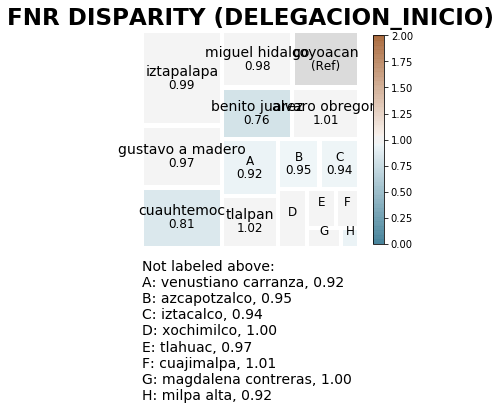

In [26]:
aqp.plot_disparity(bdf, group_metric='fnr_disparity',
                   attribute_name='delegacion_inicio', significance_alpha=0.05)

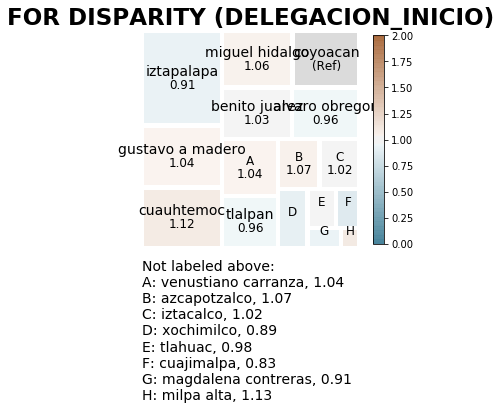

In [27]:
aqp.plot_disparity(bdf, group_metric='for_disparity',
                   attribute_name='delegacion_inicio', significance_alpha=0.05)

### Comprobación

In [4]:
model=GradientBoostingClassifier(learning_rate=0.25,
                                 subsample=1.0, max_depth=10, n_estimators=1)

model.fit(X_train_input, y_train)

/Users/pozoshidalgo/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.25, loss='deviance', max_depth=10,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [5]:
new_proba = model.predict_proba(X_test_input)
ynew_etiqueta = model.predict(X_test_input)  #Aequitas necesita la etiqueta

In [15]:
#Hace concatenate de columnas X_test, y_test y la etiqueta de la prediccion
df_aequitas = pd.concat([X_test['delegacion_inicio'],
                         y_test,   #target
                         pd.DataFrame(ynew_etiqueta, index=X_test.index)],  #0
                        axis=1, sort=False)

In [16]:
df_aequitas

,delegacion_inicio,target,0
0,benito juarez,1,0
1,cuauhtemoc,0,0
2,tlahuac,0,0
3,iztapalapa,1,0
4,cuauhtemoc,1,0
...,...,...,...
390933,cuauhtemoc,1,0
390934,cuauhtemoc,0,0
390935,benito juarez,1,1
390936,iztapalapa,0,0


In [ ]:
#Renombra columnas
df_aequitas.rename(columns={'target': 'label_value',
                            0: 'score'}, inplace=True)

#Asigna tipo apropiado de variable
df_aequitas[df_aequitas.columns.difference(['label_value', 'score'])] = df_aequitas[
    df_aequitas.columns.difference(['label_value', 'score'])].astype(str)

In [38]:
df_aequitas

,delegacion_inicio,label_value,score
0,benito juarez,1,0
1,cuauhtemoc,0,0
2,tlahuac,0,0
3,iztapalapa,1,0
4,cuauhtemoc,1,0
...,...,...,...
390933,cuauhtemoc,1,0
390934,cuauhtemoc,0,0
390935,benito juarez,1,1
390936,iztapalapa,0,0


In [39]:
g = Group()
xtab, _ = g.get_crosstabs(df_aequitas)

model_id, score_thresholds 1 {'rank_abs': [29745]}


In [40]:
#Obtiene todas las metricas absolutas
absolute_metrics = g.list_absolute_metrics(xtab)
xtab[[col for col in xtab.columns if col not in absolute_metrics]]

,model_id,score_threshold,k,attribute_name,attribute_value,pp,pn,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities
0,1,binary 0/1,29745,delegacion_inicio,alvaro obregon,1145,27743,114,10733,17010,1031,11764,17124,28888,390938
1,1,binary 0/1,29745,delegacion_inicio,azcapotzalco,1217,15987,79,6885,9102,1138,8023,9181,17204,390938
2,1,binary 0/1,29745,delegacion_inicio,benito juarez,5950,23861,1352,9894,13967,4598,14492,15319,29811,390938
3,1,binary 0/1,29745,delegacion_inicio,coyoacan,1436,30001,126,12104,17897,1310,13414,18023,31437,390938
4,1,binary 0/1,29745,delegacion_inicio,cuajimalpa,272,7339,33,2461,4878,239,2700,4911,7611,390938
5,1,binary 0/1,29745,delegacion_inicio,cuauhtemoc,6443,33886,868,15295,18591,5575,20870,19459,40329,390938
6,1,binary 0/1,29745,delegacion_inicio,gustavo a madero,2533,38485,166,16180,22305,2367,18547,22471,41018,390938
7,1,binary 0/1,29745,delegacion_inicio,iztacalco,1241,15245,117,6266,8979,1124,7390,9096,16486,390938
8,1,binary 0/1,29745,delegacion_inicio,iztapalapa,2819,60030,282,21947,38083,2537,24484,38365,62849,390938
9,1,binary 0/1,29745,delegacion_inicio,magdalena contreras,233,5397,20,1992,3405,213,2205,3425,5630,390938


In [41]:
xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,delegacion_inicio,alvaro obregon,0.09,0.99,0.39,0.10,0.01,0.91,0.61,0.90,0.04,0.04,0.41
1,delegacion_inicio,azcapotzalco,0.14,0.99,0.43,0.06,0.01,0.86,0.57,0.94,0.04,0.07,0.47
2,delegacion_inicio,benito juarez,0.32,0.91,0.41,0.23,0.09,0.68,0.59,0.77,0.20,0.20,0.49
3,delegacion_inicio,coyoacan,0.10,0.99,0.40,0.09,0.01,0.90,0.60,0.91,0.05,0.05,0.43
4,delegacion_inicio,cuajimalpa,0.09,0.99,0.34,0.12,0.01,0.91,0.66,0.88,0.01,0.04,0.35
5,delegacion_inicio,cuauhtemoc,0.27,0.96,0.45,0.13,0.04,0.73,0.55,0.87,0.22,0.16,0.52
6,delegacion_inicio,gustavo a madero,0.13,0.99,0.42,0.07,0.01,0.87,0.58,0.93,0.09,0.06,0.45
7,delegacion_inicio,iztacalco,0.15,0.99,0.41,0.09,0.01,0.85,0.59,0.91,0.04,0.08,0.45
8,delegacion_inicio,iztapalapa,0.10,0.99,0.37,0.10,0.01,0.90,0.63,0.90,0.09,0.04,0.39
9,delegacion_inicio,magdalena contreras,0.10,0.99,0.37,0.09,0.01,0.90,0.63,0.91,0.01,0.04,0.39


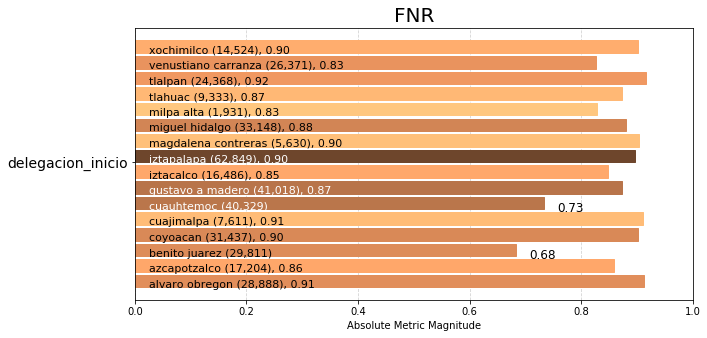

In [42]:
aqp = Plot()
fnr = aqp.plot_group_metric(xtab, 'fnr')

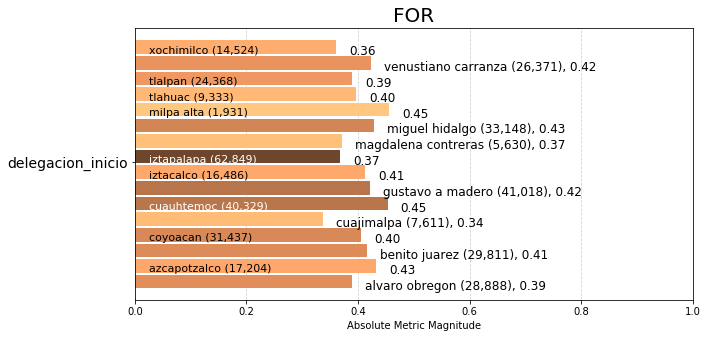

In [43]:
fnr = aqp.plot_group_metric(xtab, 'for')

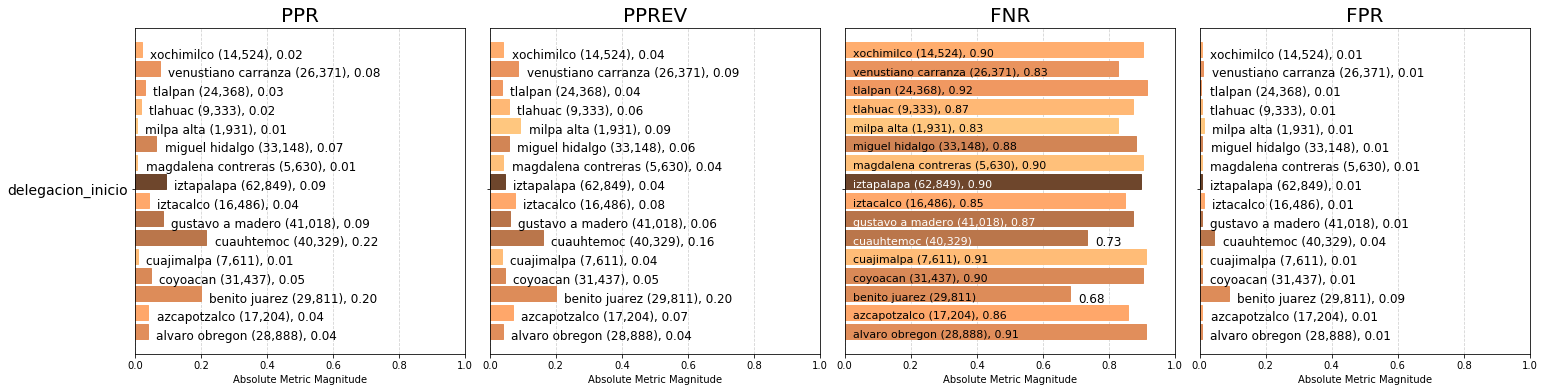

In [44]:
p = aqp.plot_group_metric_all(xtab, metrics=['ppr','pprev','fnr','fpr'], ncols=4)

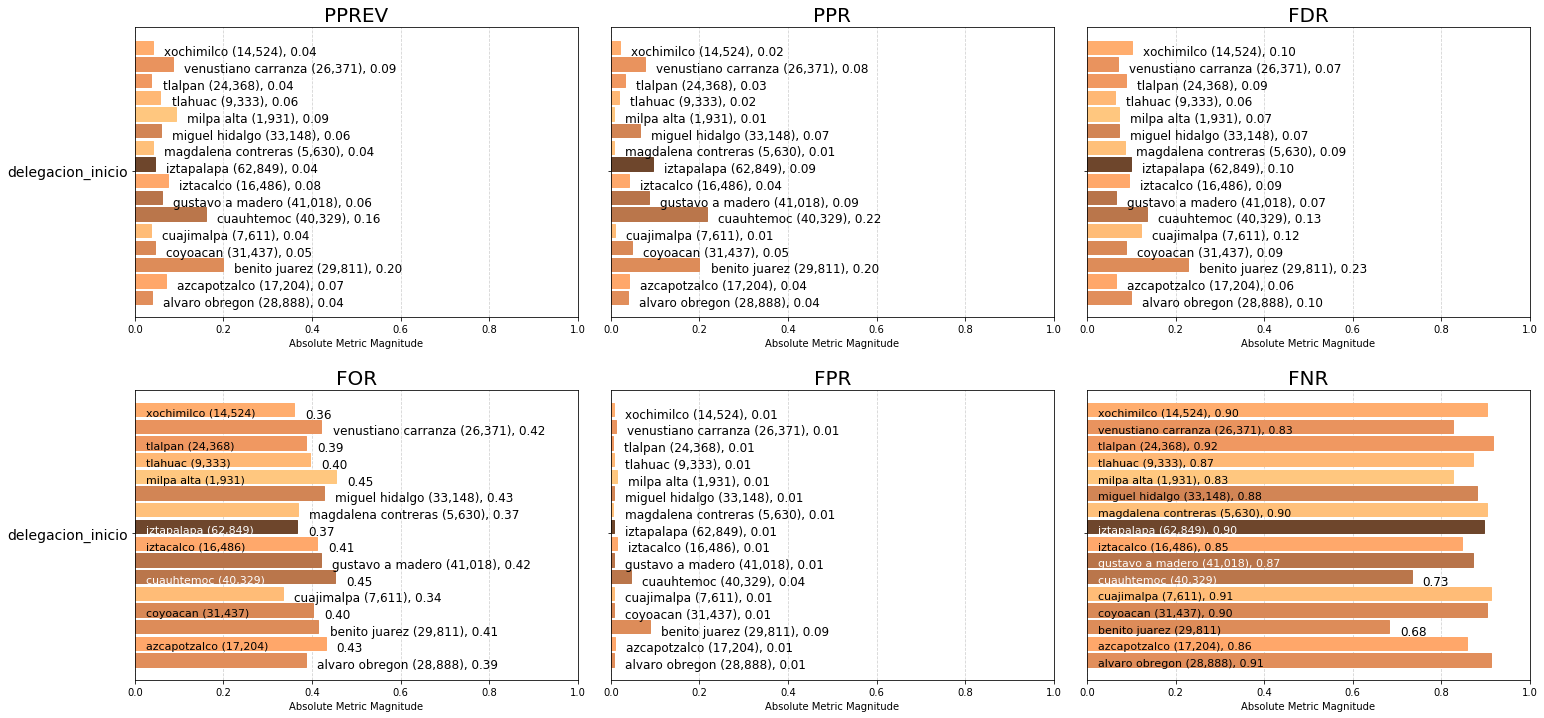

In [45]:
a = aqp.plot_group_metric_all(xtab, ncols=3)

In [28]:
#Suponiendo el modelo ganador es regresión logística
#model=LogisticRegression(penalty='l1',C=0.001)
#model.fit(X_train_input, y_train)
#new_proba = model.predict_proba(X_test_input)
#ynew_etiqueta = model.predict(X_test_input)  #Aequitas necesita la etiqueta
#ynew_etiqueta
#Hace concatenate de columnas X_test, y_test y la etiqueta de la prediccion
#df_aequitas = pd.concat([X_test['delegacion_inicio'],
#                         y_test,
#                         pd.DataFrame(ynew_etiqueta, index=X_test.index)],
#                        axis=1, sort=False)

#Renombra columnas
#df_aequitas.rename(columns={'target': 'label_value',
#                            0: 'score'}, inplace=True)

#Asigna tipo apropiado de variable
#df_aequitas[df_aequitas.columns.difference(['label_value', 'score'])] = df_aequitas[
#    df_aequitas.columns.difference(['label_value', 'score'])].astype(str)
#g = Group()
#xtab, _ = g.get_crosstabs(df_aequitas)
#Obtiene todas las metricas absolutas
#absolute_metrics = g.list_absolute_metrics(xtab)
#xtab[[col for col in xtab.columns if col not in absolute_metrics]]
#xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)